In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

## Parameters

In [2]:
# programm parameters
arr_length = 1000000 # array length of x-coordinate (how precise hitting point is)
binsize = 5 # in degrees for plotting

def thetas(start=2.5, end=90.5, step=5):
    theta_deg = np.arange(start, end, step)
    theta_rad = np.deg2rad(theta_deg)
    return theta_deg, theta_rad


theta_deg, theta_rad = thetas()

In [48]:
# building parameters

thickness = 40 #of ceiling
length = 1000 #of the ceiling
height = 290 #distance between ceilings

def ceil(thickness, height):
    #define y positions of the ceilings
    y11 = height * 1 # maybe substract tableheight
    y12 = height * 1 + thickness * 1
    y21 = height * 2 + thickness * 1
    y22 = height * 2 + thickness * 2
    y31 = height * 3 + thickness * 2
    y32 = height * 3 + thickness * 3 # (add height for thicker roof)
    
    ceilings = np.array([[y11, y12], [y21, y22], [y31, y32]])
    return ceilings


def ceil_basement(thickness, height):
    #define y positions of the ceilings
    y11 = height * 1 # maybe substract tableheight
    y12 = height * 1 + thickness * 1
    y21 = height * 2 + thickness * 1
    y22 = height * 2 + thickness * 2
    y31 = height * 3 + thickness * 2
    y32 = height * 3 + thickness * 3
    y41 = height * 4 + thickness * 3
    y42 = height * 4 + thickness * 4
    y51 = height * 5 + thickness * 4
    y52 = height * 5 + thickness * 5
    
    
    ceilings = np.array([[y11, y12], [y21, y22], [y31, y32], [y41, y42], [y51,y52]])
    return ceilings


def ceil_3(thickness, height):
    #define y positions of the ceilings
    y11 = height * 1 # maybe substract tableheight
    y12 = height * 1 + thickness * 1
    
    ceilings = np.array([[y11, y12]])
    return ceilings
    

ceilings = ceil(thickness, height)

In [4]:
# muon constants
# parameters at 0° sea level (durham UK)
I0 = 72.5 # m^-2 s^-1 sr^-1
n = 3.06
E0 = 3.87 # GeV
epsilon = 854
R = 6360 # km
d = 10 # km
Ec = 0 # GeV (cut-off value of the data)
N = (n-1)*(E0 + Ec)**(n-1)

## Pathlength Calculation

In [5]:
def get_slab_path_length(theta_rad, y_bottom, y_top, max_x):

    # Avoid division by zero for perfectly horizontal rays
    if np.isclose(theta_rad, np.pi/2):
        return 0.0   

    slab_thickness = y_top - y_bottom
    raw_path = slab_thickness / np.cos(theta_rad)
    
    # 2. Check Building Constraints (Finite Length)
    # Calculate x-position where the ray enters and exits the slab layer
    tan_theta = np.tan(theta_rad)
    x_enter = y_bottom * tan_theta
    x_exit  = y_top * tan_theta
    
    # Case A: Ray starts beyond the building length (misses entirely)
    if x_enter >= max_x:
        return 0.0
    
    # Case B: Ray exits through the side wall (clips the corner)
    if x_exit > max_x:
        # Calculate distance from entry point (x_enter, y_bottom) to corner (max_x, y_corner)
        # We need to find y at x=max_x -> y = x / tan(theta)
        y_at_wall = max_x / tan_theta
        
        # Distance formula between (x_enter, y_bottom) and (max_x, y_at_wall)
        dx = max_x - x_enter
        dy = y_at_wall - y_bottom
        return np.sqrt(dx**2 + dy**2)
        
    # Case C: Standard transmission (enters bottom, exits top)
    return raw_path


def total_path(theta_rad, ceilings=ceilings):
    # Sum the path lengths through all defined ceilings
    total = 0.0
    for y_bot, y_top in ceilings:
        total += get_slab_path_length(theta_rad, y_bot, y_top, length)
    return total

In [6]:
def loop(theta_rad, func, ceiling=ceilings):
    arr = np.array([func(theta, ceiling) for theta in theta_rad])   
    return arr

In [7]:
print(loop(theta_rad, total_path))

[120.11432222 121.03547527 122.91354172 125.82349502 129.88706404
 135.28583362 142.28268569 151.25668968 162.76100459 177.62246795
 131.41437054 148.89271974  86.62722281 104.52503719 133.02038094
   0.           0.           0.        ]


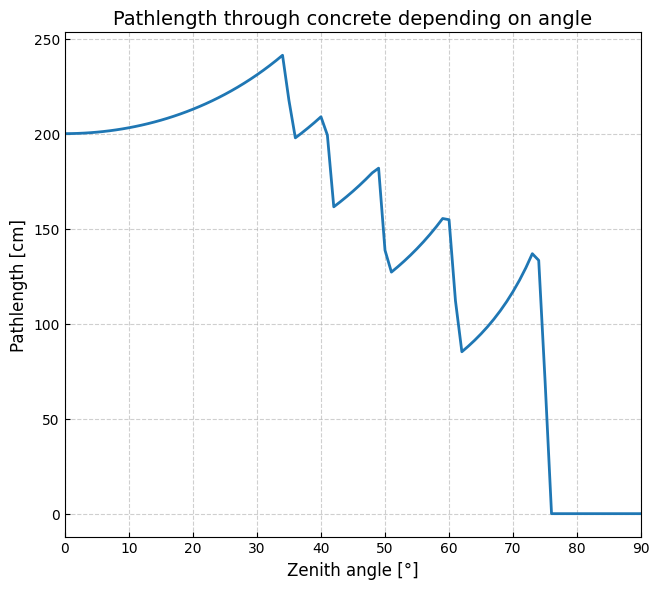

In [8]:
plt.figure(figsize=(6.7, 6))  # (width, height in inches)
t = thetas(0, 90.5, 1)

plt.plot(t[0], loop(t[1], total_path, ceil_basement(40, 250)), linewidth = 2)

plt.title('Pathlength through concrete depending on angle', fontsize=14)#, fontweight='bold')
plt.xlabel('Zenith angle [°]', fontsize=12)
plt.ylabel('Pathlength [cm]', fontsize=12)


plt.xlim(0, 90)
#plt.ylim(0, 7e6)

# plt.xticks(np.arange(0, 11, 2))  # Set x-ticks at 0, 2, 4, 6, 8, 10
# plt.yticks(np.arange(0, 9, 1))   # Set y-ticks at 0, 1, 2, ... 8

plt.tick_params(axis='both', which='major', labelsize=10, direction='in')

# plt.legend(loc='upper right', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

## Calculate complete energy loss

$E_{loss} = \frac{dE}{dx} * \rho * l$

In [9]:
dEdx = 0.004 # GeV cm^2/g for muons 2 to 3 GeV (2 MeV/cm for muon with constant 2 GeV, and 4 MeV/cm for distribution (Geant4)
rho = 2.3 # g/cm^3 for concrete

def E_loss(theta_rad, ceilings=ceilings):
    return dEdx * rho * total_path(theta_rad, ceilings)

In [10]:
print(loop(theta_rad, E_loss))

[1.10505176 1.11352637 1.13080458 1.15757615 1.19496099 1.24462967
 1.30900071 1.39156155 1.49740124 1.63412671 1.20901221 1.36981302
 0.79697045 0.96163034 1.2237875  0.         0.         0.        ]


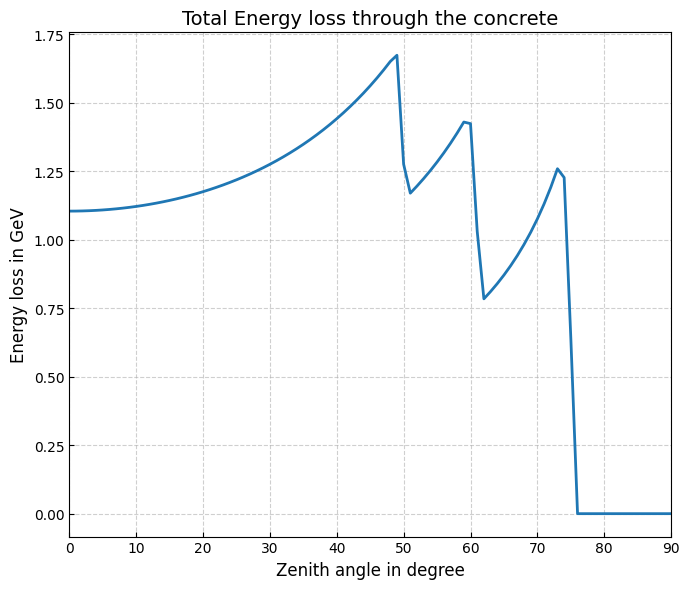

In [11]:
plt.figure(figsize=(7, 6))  # (width, height in inches)
t = thetas(0, 90.5, 1)

plt.plot(t[0], loop(t[1], E_loss), linewidth = 2)

plt.title('Total Energy loss through the concrete', fontsize=14)#, fontweight='bold')
plt.xlabel('Zenith angle in degree', fontsize=12)
plt.ylabel('Energy loss in GeV', fontsize=12)


plt.xlim(0, 90)
#plt.ylim(0, 7e6)

# plt.xticks(np.arange(0, 11, 2))  # Set x-ticks at 0, 2, 4, 6, 8, 10
# plt.yticks(np.arange(0, 9, 1))   # Set y-ticks at 0, 1, 2, ... 8

plt.tick_params(axis='both', which='major', labelsize=10, direction='in')

# plt.legend(loc='upper right', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

## Calculate muon flux from Shukla equation

$I(E, \theta) = I_0 N (E_0 + E)^{-n} D(\theta)^{-(n-1)}$

$D_2(\theta) = \frac{1}{cos(\theta)}$

In [12]:
def D_theta(theta_rad, R=R, d=d):
    R_d = R / d
    cos_theta = np.cos(theta_rad)
    D_val = np.sqrt(R_d**2 * cos_theta**2 + 2 * R_d + 1) - (R_d * cos_theta)
    return D_val


def cos2(theta_rad):
    return np.cos(theta_rad)**2


def I_E_theta(E, I0, N, E0, n, theta_rad, dterm=2):
    if dterm == 1:
        D_term = D_theta(theta_rad, R, d)**(-(n - 1))
    elif dterm == 2:
        D_term = cos2(theta_rad)
    else:
        print("Error: dterm not valid")

    E_term = (E0 + E)**(-n)
    e_corr = (1+ E/epsilon)**(-1)
    return I0 * N * E_term * dterm * e_corr # * np.sin(theta_rad)

In [13]:
def integrate_I_analy(theta_rad, Emin, Emax):
    # I0 * N * cos^2(theta) * Energy_Integral_Term
    term_energy = (1/(-n + 1)) * ((E0 + Emax)**(-n + 1) - (E0 + Emin)**(-n + 1))
    return I0 * N * cos2(theta_rad) * term_energy


def mean_cos2(theta_min, binsize=binsize):
    result, error = quad(cos2, theta_min, theta_min + np.deg2rad(binsize))
    return 1/(theta_min+np.deg2rad(binsize)-theta_min)*result


def mean_theta(theta_min, binsize=binsize):
    return np.arccos(np.sqrt(mean_cos2(theta_min, binsize)))

In [14]:
def I_in(theta, ceilings=ceilings):
    # If theta is extremely close to pi/2 (horizon), usually 0 flux or cutoff
    if theta > 1.56: # ~89 degrees
        return 0
        
    energy_loss = E_loss(theta, ceilings)
    val = integrate_I_analy(theta, energy_loss, 1000)
    return val


def I_in_int(theta, ceilings=ceilings):
    return I_in(theta, ceilings) * np.sin(theta) * 2 * np.pi


def I_out(theta, ceilings=ceilings):
    if theta > 1.56: # ~89 degrees
        return 0

    energy_loss = E_loss(theta, ceilings)
    val = integrate_I_analy(theta, 0, 1000)
    return val


def I_out_int(theta, ceilings=ceilings):
    return I_out(theta, ceilings) * np.sin(theta) * 2 * np.pi

In [15]:
theta_starts = thetas(0, 90, binsize)

I_outside = np.array([I_out(mean_theta(theta)) for theta in theta_starts[1]])
print(I_outside)

[72.31547046 71.21962766 69.0612387  65.90588512 61.84944075 57.01515861
 51.5499259  45.61980095 39.40496762 33.09426047 26.87942714 20.94930219
 15.48406948 10.64978733  6.59334297  3.43798939  1.27960043  0.18375763]


In [16]:
I_inside = np.array([I_in(mean_theta(theta)) for theta in theta_starts[1]])
print(I_inside)

[43.09696295 42.29539282 40.72232196 38.43684925 35.52504854 32.09694797
 28.28261131 24.22740142 20.08650851 16.01881092 15.35475951 11.22452954
 10.53138589  6.74624246  3.74884793  3.43798939  1.27960043  0.18375763]


In [17]:
result, error = quad(I_in_int, 0, np.pi/2, limit=100, args=ceilings)

print(f"Result inside: {result}")
print(f"Error:  {error}")

Result inside: 85.84784501709366
Error:  1.013451736753268e-06


In [18]:
result, error = quad(I_out_int, 0, np.pi/2, limit=100, args=ceilings)

print(f"Result outside: {result}")
print(f"Error:  {error}")

Result outside: 151.84183713050956
Error:  1.3370579665661353e-06


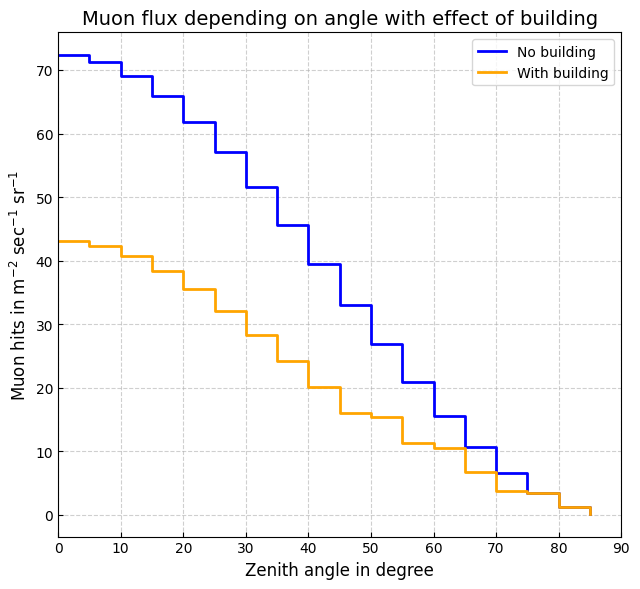

In [19]:
plt.figure(figsize=(6.5, 6))  # (width, height in inches)

plt.step(theta_starts[0], I_outside, where='post', label='No building', color='b', linewidth=2)
plt.step(theta_starts[0], I_inside, where='post', label='With building', color='orange', linewidth=2)
#plt.step(theta_starts[0], I_inside/I_outside*100, where='pre', label='Ratio in/out', color='green', linewidth=2)

plt.title('Muon flux depending on angle with effect of building', fontsize=14)#, fontweight='bold')
plt.xlabel('Zenith angle in degree', fontsize=12)
plt.ylabel(r'Muon hits in $\text{m}^{-2} \text{ sec}^{-1} \text{ sr}^{-1}$', fontsize=12)


plt.xlim(0, 90)
#plt.ylim(0, 7e6)

# plt.xticks(np.arange(0, 11, 2))  # Set x-ticks at 0, 2, 4, 6, 8, 10
# plt.yticks(np.arange(0, 9, 1))   # Set y-ticks at 0, 1, 2, ... 8

plt.tick_params(axis='both', which='major', labelsize=10, direction='in')

plt.legend(loc='upper right', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

## Calculate muon flux depending on wall thickness

In [20]:
c = ceil(60, 250)
paths = np.array([total_path(theta, c) for theta in theta_rad])
paths

array([180.17148333, 181.5532129 , 184.37031258, 188.73524253,
       194.83059605, 202.92875044, 213.42402854, 226.88503452,
       244.14150688, 246.20128022, 197.1215558 , 223.3390796 ,
       129.94083421, 156.78755579, 199.53057141,   0.        ,
         0.        ,   0.        ])

In [21]:
def muon_flux(thickness, height, ceilingf=ceil, angle=np.pi/2):
    c = ceilingf(thickness, height)
    result, error = quad(I_in_int, 0, angle, limit=150, args=c)
    return result

In [22]:
muon_flux(100, 250)

49.40357698310703

In [23]:
t = np.arange(0, 100, 1)
flux_t = np.array([muon_flux(thick, 250) for thick in t])
flux_t

/tmp/ipykernel_3742552/217043417.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = quad(I_in_int, 0, angle, limit=150, args=c)


array([151.84183713, 149.2242049 , 146.68125544, 144.21008124,
       141.80792562, 139.47216472, 137.20030484, 134.98997099,
       132.83890122, 130.74493898, 128.70603019, 126.72021319,
       124.78561428, 122.90045067, 121.06300926, 119.27165743,
       117.52483463, 115.82104569, 114.15885995, 112.53690682,
       110.95387342, 109.40850123, 107.89958329, 106.4259618 ,
       104.98652456, 103.58020741, 102.20598386, 100.8628691 ,
        99.54991759,  98.26621941,  97.01089954,  95.7831165 ,
        94.58205838,  93.40694681,  92.25702956,  91.13158927,
        90.02990882,  88.95133489,  87.89521345,  86.86091783,
        85.84784502,  84.85541251,  83.88305775,  82.93023793,
        81.99642835,  81.08112167,  80.18383034,  79.30407826,
        78.44140911,  77.59537978,  76.76556182,  75.95154114,
        75.15291641,  74.36929931,  73.6003187 ,  72.84559638,
        72.10479809,  71.37756822,  70.66357472,  69.96250841,
        69.27404963,  68.59789927,  67.93376783,  67.28

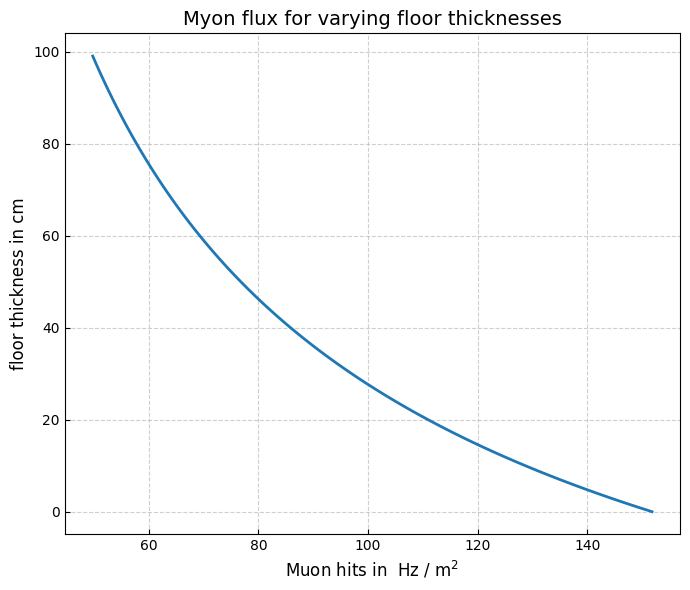

In [24]:
plt.figure(figsize=(7, 6))  # (width, height in inches)


plt.plot(flux_t, t, linewidth = 2)

plt.title('Myon flux for varying floor thicknesses', fontsize=14)#, fontweight='bold')
plt.xlabel(r'Muon hits in $\text{ Hz }/\text{ m}^{2}$', fontsize=12)
plt.ylabel('floor thickness in cm', fontsize=12)


#plt.xlim(0, 90)
#plt.ylim(0, 7e6)

# plt.xticks(np.arange(0, 11, 2))  # Set x-ticks at 0, 2, 4, 6, 8, 10
# plt.yticks(np.arange(0, 9, 1))   # Set y-ticks at 0, 1, 2, ... 8

plt.tick_params(axis='both', which='major', labelsize=10, direction='in')

# plt.legend(loc='upper right', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

## Basement

In [25]:
theta_starts = thetas(0, 90, binsize)

I_outbase = np.array([I_out(mean_theta(theta), ceil_basement(thickness, height)) for theta in theta_starts[1]])
print(I_outside)

I_inbase = np.array([I_in(mean_theta(theta), ceil_basement(thickness, height)) for theta in theta_starts[1]])
print(I_inside)

[72.31547046 71.21962766 69.0612387  65.90588512 61.84944075 57.01515861
 51.5499259  45.61980095 39.40496762 33.09426047 26.87942714 20.94930219
 15.48406948 10.64978733  6.59334297  3.43798939  1.27960043  0.18375763]
[43.09696295 42.29539282 40.72232196 38.43684925 35.52504854 32.09694797
 28.28261131 24.22740142 20.08650851 16.01881092 15.35475951 11.22452954
 10.53138589  6.74624246  3.74884793  3.43798939  1.27960043  0.18375763]


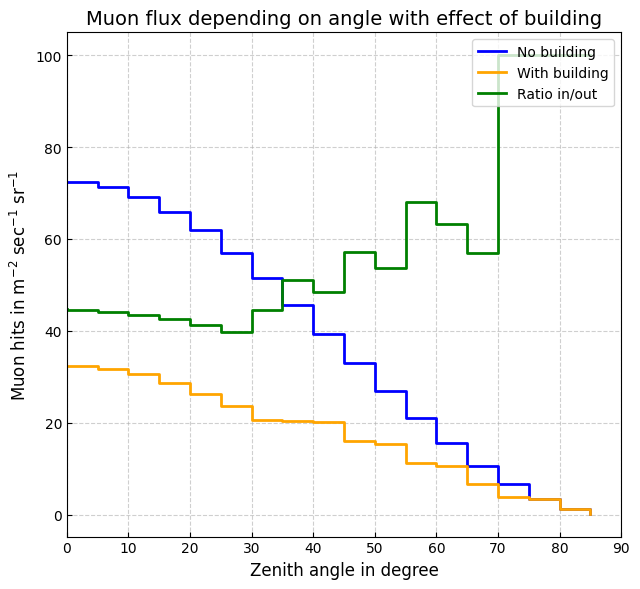

In [26]:
plt.figure(figsize=(6.5, 6))  # (width, height in inches)


plt.step(theta_starts[0], I_outbase, where='post', label='No building', color='b', linewidth=2)
plt.step(theta_starts[0], I_inbase, where='post', label='With building', color='orange', linewidth=2)
plt.step(theta_starts[0], I_inbase/I_outbase*100, where='pre', label='Ratio in/out', color='green', linewidth=2)

plt.title('Muon flux depending on angle with effect of building', fontsize=14)#, fontweight='bold')
plt.xlabel('Zenith angle in degree', fontsize=12)
plt.ylabel(r'Muon hits in $\text{m}^{-2} \text{ sec}^{-1} \text{ sr}^{-1}$', fontsize=12)


plt.xlim(0, 90)
#plt.ylim(0, 7e6)

# plt.xticks(np.arange(0, 11, 2))  # Set x-ticks at 0, 2, 4, 6, 8, 10
# plt.yticks(np.arange(0, 9, 1))   # Set y-ticks at 0, 1, 2, ... 8

plt.tick_params(axis='both', which='major', labelsize=10, direction='in')

plt.legend(loc='upper right', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

## Top Floor

In [27]:
theta_starts = thetas(0, 90, 5)

I_outtop = np.array([I_out(mean_theta(theta), ceil_3(thickness, height)) for theta in theta_starts[1]])
print(I_outside)

I_intop = np.array([I_in(mean_theta(theta), ceil_3(thickness, height)) for theta in theta_starts[1]])
print(I_inside)

[72.31547046 71.21962766 69.0612387  65.90588512 61.84944075 57.01515861
 51.5499259  45.61980095 39.40496762 33.09426047 26.87942714 20.94930219
 15.48406948 10.64978733  6.59334297  3.43798939  1.27960043  0.18375763]
[43.09696295 42.29539282 40.72232196 38.43684925 35.52504854 32.09694797
 28.28261131 24.22740142 20.08650851 16.01881092 15.35475951 11.22452954
 10.53138589  6.74624246  3.74884793  3.43798939  1.27960043  0.18375763]


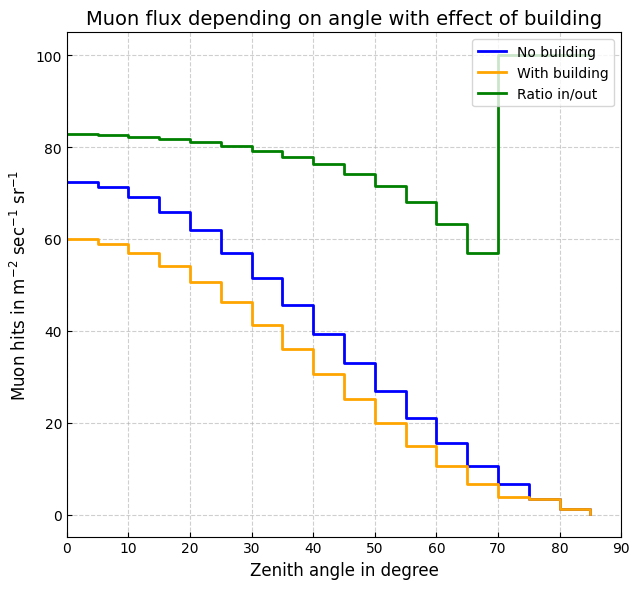

In [28]:
plt.figure(figsize=(6.5, 6))  # (width, height in inches)


plt.step(theta_starts[0], I_outtop, where='post', label='No building', color='b', linewidth=2)
plt.step(theta_starts[0], I_intop, where='post', label='With building', color='orange', linewidth=2)
plt.step(theta_starts[0], I_intop/I_outtop*100, where='pre', label='Ratio in/out', color='green', linewidth=2)

plt.title('Muon flux depending on angle with effect of building', fontsize=14)#, fontweight='bold')
plt.xlabel('Zenith angle in degree', fontsize=12)
plt.ylabel(r'Muon hits in $\text{m}^{-2} \text{ sec}^{-1} \text{ sr}^{-1}$', fontsize=12)


plt.xlim(0, 90)
#plt.ylim(0, 7e6)

# plt.xticks(np.arange(0, 11, 2))  # Set x-ticks at 0, 2, 4, 6, 8, 10
# plt.yticks(np.arange(0, 9, 1))   # Set y-ticks at 0, 1, 2, ... 8

plt.tick_params(axis='both', which='major', labelsize=10, direction='in')

plt.legend(loc='upper right', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

## Top floor vs Basement

In [29]:
I_intop = np.array([I_in(mean_theta(theta), ceil_3(thickness, height)) for theta in theta_starts[1]])
print(I_inside)

I_inbase = np.array([I_in(mean_theta(theta), ceil_basement(thickness, height)) for theta in theta_starts[1]])
print(I_inside)

[43.09696295 42.29539282 40.72232196 38.43684925 35.52504854 32.09694797
 28.28261131 24.22740142 20.08650851 16.01881092 15.35475951 11.22452954
 10.53138589  6.74624246  3.74884793  3.43798939  1.27960043  0.18375763]
[43.09696295 42.29539282 40.72232196 38.43684925 35.52504854 32.09694797
 28.28261131 24.22740142 20.08650851 16.01881092 15.35475951 11.22452954
 10.53138589  6.74624246  3.74884793  3.43798939  1.27960043  0.18375763]


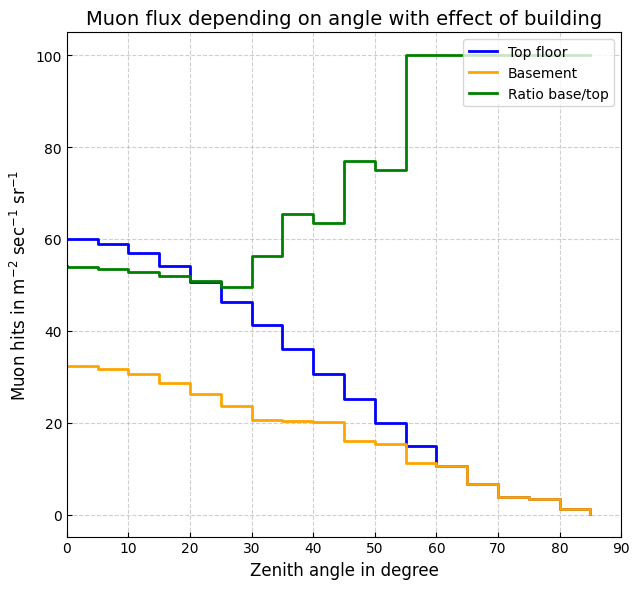

In [30]:
plt.figure(figsize=(6.5, 6))  # (width, height in inches)


plt.step(theta_starts[0], I_intop, where='post', label='Top floor', color='b', linewidth=2)
plt.step(theta_starts[0], I_inbase, where='post', label='Basement', color='orange', linewidth=2)
plt.step(theta_starts[0], I_inbase/I_intop*100, where='pre', label='Ratio base/top', color='green', linewidth=2)

plt.title('Muon flux depending on angle with effect of building', fontsize=14)#, fontweight='bold')
plt.xlabel('Zenith angle in degree', fontsize=12)
plt.ylabel(r'Muon hits in $\text{m}^{-2} \text{ sec}^{-1} \text{ sr}^{-1}$', fontsize=12)


plt.xlim(0, 90)
#plt.ylim(0, 7e6)

# plt.xticks(np.arange(0, 11, 2))  # Set x-ticks at 0, 2, 4, 6, 8, 10
# plt.yticks(np.arange(0, 9, 1))   # Set y-ticks at 0, 1, 2, ... 8

plt.tick_params(axis='both', which='major', labelsize=10, direction='in')

plt.legend(loc='upper right', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

In [31]:
t = np.arange(0, 100, 1)
flux_t_top = np.array([muon_flux(thick, 250, ceil_3) for thick in t])
flux_t_base = np.array([muon_flux(thick, 250, ceil_basement) for thick in t])

/tmp/ipykernel_3742552/217043417.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = quad(I_in_int, 0, angle, limit=150, args=c)


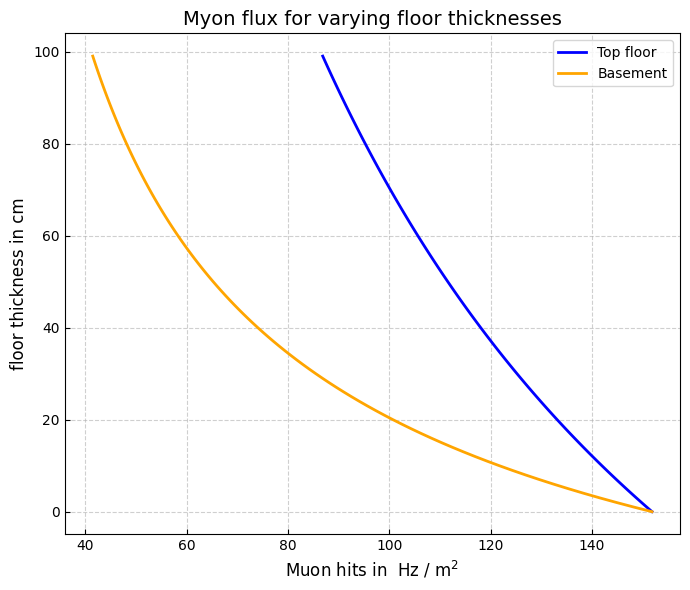

In [32]:
plt.figure(figsize=(7, 6))  # (width, height in inches)


plt.plot(flux_t_top, t, linewidth = 2, label ='Top floor', color = 'blue')
plt.plot(flux_t_base, t, linewidth = 2, label ='Basement', color = 'orange')

plt.title('Myon flux for varying floor thicknesses', fontsize=14)#, fontweight='bold')
plt.xlabel(r'Muon hits in $\text{ Hz }/\text{ m}^{2}$', fontsize=12)
plt.ylabel('floor thickness in cm', fontsize=12)


#plt.xlim(0, 90)
#plt.ylim(0, 7e6)

# plt.xticks(np.arange(0, 11, 2))  # Set x-ticks at 0, 2, 4, 6, 8, 10
# plt.yticks(np.arange(0, 9, 1))   # Set y-ticks at 0, 1, 2, ... 8

plt.tick_params(axis='both', which='major', labelsize=10, direction='in')

plt.legend(loc='upper right', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

## Detector Set up 1 (two detectors in vertical distance d)

In [49]:
def muon_flux(thickness, height, ceilingf=ceil, angle=np.pi/2):
    c = ceilingf(thickness, height)
    result, error = quad(I_in_int, 0, angle, limit=150, args=c)
    return result

In [50]:
acc_angle = 30

In [60]:
lab30 = muon_flux(40, 290, ceil, np.deg2rad(acc_angle))
lab30

30.751556529551525

In [58]:
labmuon_s = lab30 * 0.4 * 0.4
labmuon_s

4.093244694942162

In [59]:
labtotal4 = labmuon_s * 4 * 60 * 60
labtotal4

58942.72360716713

In [38]:
base30 = muon_flux(40, 250, ceil_basement, np.deg2rad(acc_angle))
base30

22.823721357520494

In [39]:
top30 = muon_flux(40, 250, ceil_3, np.deg2rad(acc_angle))
top30

43.590330977340784

In [40]:
basemuons_s = base30 * 0.4 * 0.4
basemuons_s # muons per second

3.65179541720328

In [41]:
topmuons_s = top30 * 0.4 * 0.4
topmuons_s

6.974452956374527

In [42]:
fourhours = 4 * 60 * 60
basetotal4 = basemuons_s * fourhours
print(basetotal4)
print(np.sqrt(basetotal4))

52585.85400772723
229.3160570211498


In [43]:
toptotal4 = topmuons_s * fourhours
print(toptotal4)
print(np.sqrt(toptotal4))

100432.12257179318
316.9102752701357


In [44]:
t = np.arange(0, 100, 1)
flux_t_top = np.array([muon_flux(thick, 250, ceil_3, np.deg2rad(acc_angle)) for thick in t])
flux_t_base = np.array([muon_flux(thick, 250, ceil_basement, np.deg2rad(acc_angle)) for thick in t])

In [45]:
flux_t_base*fourhours*0.4*0.4

array([122613.66806566, 119462.85664646, 116431.0228264 , 113512.26914664,
       110701.05862915, 107992.1886639 , 105380.76707693, 102862.19017344,
       100432.12257179,  98086.47866323,  95821.40554935,  93633.267324  ,
        91518.63058004,  89474.25103286,  87497.06116351,  85584.15879351,
        83732.79651187,  81940.37188245,  80204.41836652,  78522.59690144,
        76892.68808179,  75312.58489421,  73780.28596155,  72293.88925596,
        70851.58624409,  69451.65643075,  68092.46227039,  66772.44441826,
        65490.11729566,  64244.06494573,  63032.93715822,  61855.44584347,
        60710.3616375 ,  59596.51072145,  58512.77184013,  57458.07350551,
        56431.39137216,  55431.74577269,  54458.19940212,  53509.85514097,
        52585.85400773,  51685.37323188,  50807.62443953,  49951.85194417,
        49117.33113561,  48303.36696077,  47509.29249033,  46734.46756582,
        45978.27752196,  45240.13197945,  44519.46370407,  43815.72752757,
        43128.39932691,  

In [46]:
flux_t_top*fourhours*0.4*0.4

array([122613.66806566, 121973.69166851, 121338.67291636, 120708.56089632,
       120083.30534658, 119462.85664646, 118847.16580662, 118236.18445943,
       117629.86484957, 117028.1598247 , 116431.0228264 , 115838.40788119,
       115250.26959175, 114666.56312826, 114087.24421992, 113512.26914664,
       112941.59473079, 112375.17832919, 111812.97782515, 111254.95162075,
       110701.05862915, 110151.25826707, 109605.51044744, 109063.77557213,
       108526.0145248 , 107992.1886639 , 107462.25981574, 106936.19026778,
       106413.9427619 , 105895.48048787, 105380.76707693, 104869.76659541,
       104362.44353854, 103858.7628243 , 103358.68978742, 102862.19017344,
       102369.23013289, 101879.77621554, 101393.79536481, 100911.25491219,
       100432.12257179,  99956.36643502,  99483.95496524,  99014.85699265,
        98549.04170912,  98086.47866323,  97627.13775527,  97170.9892324 ,
        96718.0036839 ,  96268.15203642,  95821.40554935,  95377.73581029,
        94937.11473056,  

In [47]:
#!@#$%^&*()_+=